![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

[Dataset](https://www.kaggle.com/mkechinov/ecommerce-purchase-history-from-electronics-store)

This file contains purchase data from April 2020 to November 2020 from a large home appliances and electronics online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.


# Global Imports

In [2]:
pip install matplotlib

distutils: /usr/local/include/python3.9/UNKNOWN
sysconfig: /usr/local/include/python3.9
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.3 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 5.6 MB/s eta 0:00:01
distutils: /home/vscode/.local/include/python3.9/UNKNOWN
sysconfig: /home/vscode/.local/include/python3.9
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

# Kaggle Setup and Data Download

The dataset is hosted on Kaggle, and I didn't want to copy it into another repository and deal with license issues if they come up. To get access to the dataset, you need a kaggle account and a "token" to use with the API.


In [8]:
!KAGGLE_CONFIG_DIR=../kaggle kaggle -v

Kaggle API 1.5.12


In [9]:
!KAGGLE_CONFIG_DIR=../kaggle kaggle datasets download mkechinov/ecommerce-purchase-history-from-electronics-store

 99%|█████████████████████████████████████▋| 50.0M/50.5M [00:06<00:00, 7.83MB/s]
100%|██████████████████████████████████████| 50.5M/50.5M [00:06<00:00, 8.02MB/s]


In [10]:
!unzip ecommerce-purchase-history-from-electronics-store.zip

Archive:  ecommerce-purchase-history-from-electronics-store.zip
  inflating: kz.csv                  


# Data Exploration

In [11]:
df = pd.read_csv('kz.csv')
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


## Checking for missing values

It looks like the order and product id are always available. That is all that we will be using from this dataset, to the rest is fine.

In [12]:
df.isna().sum()

event_time             0
order_id               0
product_id             0
category_id       431954
category_code     612202
brand             506005
price             431954
user_id          2069352
dtype: int64

Let's look at the number of products and see how they are distributed among the orders. We can use the value_counts method from pandas to get an idea of how often each product is ordered.

There are 25113 unique products

Here are the counts of products ordered from largest to smallest
[44491 41076 38786 ...     1     1     1]

And a graph of what the curve looks like:


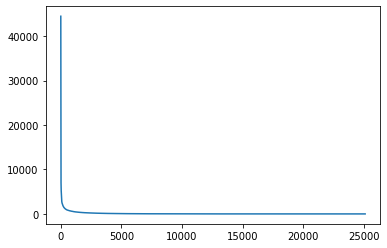

In [13]:
product_counts = df['product_id'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('Here are the counts of products ordered from largest to smallest')
print(product_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()

Wow! It looks like there are a few products that are purchased a lot. Let's take a look at those to see what they are.

In [14]:
df['product_id'].value_counts().head()

1515966223523303302    44491
1515966223523303301    41076
1515966223523303308    38786
1515966223523303310    38472
1515966223523303314    36530
Name: product_id, dtype: int64

In [15]:
print(len(df['order_id'].unique()))
print(len(df))
# from collections import Counter
# Counter(df['product_id'].value_counts().to_numpy())[3]

1435266
2633521


This is a very extreme curve. It's unlikely that we will be able to use any products that don't appear in multiple orders. We can do a few more things to see how much usable data we have.

First, we will tell value_counts to use percentages of the total instead of the sum values and divide the results equally into 10 bins.

In [16]:
df['product_id'].value_counts(normalize=True, bins=10)

(1.5150937552801208e+18, 1.6032130464058678e+18]    0.793554
(2.2139408066833234e+18, 2.3011876295801027e+18]    0.187847
(2.3011876295801027e+18, 2.388434452476882e+18]     0.018599
(1.6032130464058678e+18, 1.6904598693026473e+18]    0.000000
(1.6904598693026473e+18, 1.7777066921994266e+18]    0.000000
(1.7777066921994266e+18, 1.8649535150962058e+18]    0.000000
(1.8649535150962058e+18, 1.952200337992985e+18]     0.000000
(1.952200337992985e+18, 2.0394471608897644e+18]     0.000000
(2.0394471608897644e+18, 2.1266939837865439e+18]    0.000000
(2.1266939837865439e+18, 2.2139408066833234e+18]    0.000000
Name: product_id, dtype: float64

<AxesSubplot:>

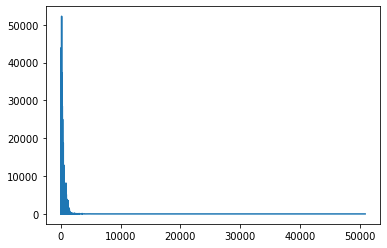

In [17]:
df['price'].value_counts().sort_index().plot()

<AxesSubplot:xlabel='order_id'>

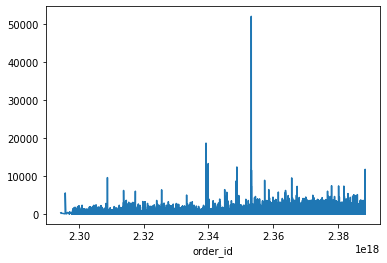

In [18]:
totals = df.groupby(df.order_id)['price'].sum()
 
totals.plot()

In [19]:
df['category_code'].value_counts()

electronics.smartphone              357682
appliances.kitchen.refrigerators     77386
16.18                                72969
electronics.video.tv                 71711
computers.notebook                   71436
                                     ...  
21.74                                    1
3.94                                     1
555.30                                   1
240.72                                   1
21.30                                    1
Name: category_code, Length: 510, dtype: int64

In [20]:
df['brand'].value_counts()

samsung                358928
ava                    118161
tefal                   78653
apple                   74709
huawei                  57438
                        ...  
1515915625444207303         1
1515915625514165334         1
1515915625514597504         1
1515915625508306506         1
1515915625514157205         1
Name: brand, Length: 23021, dtype: int64

Another thing we can do is compute the sparsity of the data. This is useful to see if there is enough overlap between the orders and products to make a useful decision for recommendations.

In [21]:
order_counts = df['order_id'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

number of orders: 1435266, number of items: 25113
matrix sparsity: 0.999927


Compare that with the 100k movielens dataset that has:

```
number of users: 943, number of items: 1682
matrix sparsity: 0.936953
```

In addition to reducing the sparsity, another issue with this dataset is the greater number of items and orders. When I tried to re-use a notebook built for the 100k movielens dataset on this ecomerce data, it immediately ran out of memory when attempting to use the KNNBasic algorithm.

In [22]:
product = 943 * 1682
print('Size for movielens: 'f'{product:,}')
 
product = 1435266 * 25113
print('Size for ecommerce dataset: 'f'{product:,}')

Size for movielens: 1,586,126
Size for ecommerce dataset: 36,043,835,058


This is a pretty clear reason why the in-memory recommendation approaches that work with movielens run out of memory when trying to apply them to the ecommerce dataset.

We need to look at reducing the dataset into something both useful and manageable. To start with, we can remove any products that don't appear more than some value.

In [23]:
#@title Example form fields
#@markdown Forms support many types of fields.
 
filter_value = 1000  #@param {type: "number"}
#@markdown

In [24]:
product_group = df.loc[:, ['order_id', 'product_id']].groupby('product_id').count()
 
multi_product = product_group[product_group.order_id >= filter_value].count()
single_product = product_group[product_group.order_id < filter_value].count()
 
print('Products in at least',filter_value,'orders:',multi_product['order_id'])
print('Products in less than',filter_value,'orders:',single_product['order_id'])
 
# We can capture the list of mutiple product orders with this:
product_filter = product_group[product_group.order_id >= filter_value].index.tolist()
 
product_filtered_df = df[df['product_id'].isin(product_filter)].copy()

Products in at least 1000 orders: 446
Products in less than 1000 orders: 24667


We can also remove orders that don't have more than some number of items.



In [25]:
#@title Example form fields
#@markdown Forms support many types of fields.
 
minimum_order_size =   3#@param {type: "number"}
maximum_order_size =   20#@param {type: "number"}
 
#@markdown

In [26]:
order_group = product_filtered_df.loc[:, ['order_id', 'product_id']].groupby('order_id').count()
 
multi_order = order_group[(order_group.product_id >= minimum_order_size) & (order_group.product_id <= maximum_order_size)].count()
single_order = order_group[(order_group.product_id < minimum_order_size) | (order_group.product_id > maximum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['product_id'])
print('Orders with less than',minimum_order_size,'products:',single_order['product_id'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.product_id >= minimum_order_size) & (order_group.product_id <= maximum_order_size)].index.tolist()

Orders with at least 3 products: 107850
Orders with less than 3 products: 612860


In [27]:
filtered_df = product_filtered_df[product_filtered_df['order_id'].isin(order_filter)].copy()
print('Original dataframe length:', len(df))
print('Filtered dataframe length:', len(filtered_df))

Original dataframe length: 2633521
Filtered dataframe length: 466561


There are 446 unique products


And a graph of what the curve looks like:


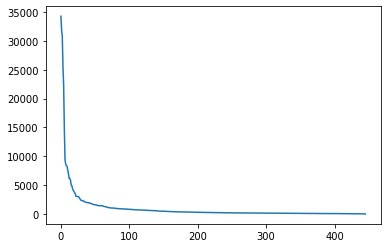

number of orders: 107850, number of items: 446
matrix sparsity: 0.945250


In [28]:
product_counts = filtered_df['product_id'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()
 
order_counts = filtered_df['order_id'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

In [29]:
filtered_df['product_id'] = filtered_df['product_id'].astype(str)

In [30]:
orderdf = filtered_df[['order_id', 'product_id']].sort_values('product_id').groupby('order_id').sum('product_id')

There are 59737 unique orders


And a graph of what the curve looks like:


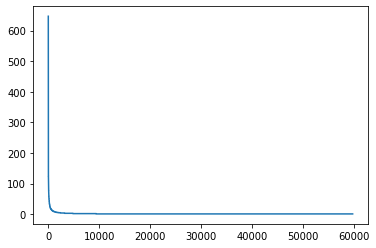

In [31]:
order_distro = orderdf['product_id'].value_counts().to_numpy()
print('There are', len(order_distro), 'unique orders\n')
print('\nAnd a graph of what the curve looks like:')
plt.plot(order_distro) 
plt.show()

# Fun with Numbers

The initial work I had done with this dataset used 1.0 as the "rating" for each product in an order. That turned out to be problematic because some algorithms multiple ratings as part of their score. And of course, this meant that a product "rated" once has the same score as a product "rated" 20 times.

Changing this "rating" to a 5 seems to move past that issue.

In [32]:
filtered_df['rating'] = 5.0
print(filtered_df)

                      event_time             order_id           product_id  \
700      2020-04-30 12:47:47 UTC  2298737347648291358  1515966223509104270   
701      2020-04-30 12:47:47 UTC  2298737347648291358  1515966223509104401   
702      2020-04-30 12:47:47 UTC  2298737347648291358  1515966223509132153   
1287     2020-05-01 13:05:09 UTC  2299470860626428718  1515966223509089486   
1288     2020-05-01 13:05:09 UTC  2299470860626428718  2273948308202324468   
...                          ...                  ...                  ...   
2632403  2020-11-19 06:19:22 UTC  2388440981134693035  2273948216221238252   
2632404  2020-11-19 12:04:30 UTC  2388440981134693036  1515966223509117074   
2632405  2020-11-19 12:04:30 UTC  2388440981134693036  1515966223523303300   
2632406  2020-11-19 12:04:30 UTC  2388440981134693036  1515966223509088578   
2632408  2020-11-19 12:04:30 UTC  2388440981134693036  1515966223509106168   

          category_id                  category_code           

In [33]:
selected_df = filtered_df[['order_id', 'product_id', 'rating']].apply(pd.to_numeric, errors='coerce').reset_index()
selected_df.info()
selected_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466561 entries, 0 to 466560
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   index       466561 non-null  int64  
 1   order_id    466561 non-null  int64  
 2   product_id  466561 non-null  int64  
 3   rating      466561 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 14.2 MB


,index,order_id,product_id,rating
0,700,2298737347648291358,1515966223509104270,5.0
1,701,2298737347648291358,1515966223509104401,5.0
2,702,2298737347648291358,1515966223509132153,5.0
3,1287,2299470860626428718,1515966223509089486,5.0
4,1288,2299470860626428718,2273948308202324468,5.0


In [34]:
pip install implicit

distutils: /usr/local/include/python3.9/UNKNOWN
sysconfig: /usr/local/include/python3.9
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.1 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 27.3 MB 8.2 MB/s eta 0:00:01    |█                               | 911 kB 4.9 MB/s eta 0:00:06     |██████████████████▍             | 15.7 MB 8.3 MB/s eta 0:00:02     |█████████████████████▏          | 18.0 MB 6.4 MB/s eta 0:00:02
  Created wheel for implicit: filename=implicit-0.4.4-cp39-cp39-linux_x86_64.whl size=3963933 sha256=7d1b96478d69dbe367a3ffe5104b032729fcdcb06c1bb0794d0ddbbbd47a3bd8
  Stored in directory: /home/vscode/.cache/pip/wheels/05/d3/5d/ab371b92ddb01183c3997751ad3bed6e6a4dd3c4c8699120a3
Successfully built implicit
distutils: /home/vscode/.local/include/python3.9/UNKNOWN
sysconfig: /home/vscode/.local/include/python3.9
user = True
home = None
root =

In [35]:
 
import implicit
import scipy
 
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)
 
# train the model on a sparse matrix of item/user/confidence weight
sparse = scipy.sparse.csr_matrix(selected_df.values)
model.fit(sparse)
 
# recommend items for a user
# user_items = item_user_data.T.tocsr()
recommendations = model.recommend(userid=0, user_items=[0], recalculate_user=True)
 
# find related items
related = model.similar_items(3000)
print(related)

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Surprise Install and Import

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 372kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617551 sha256=5852723005773bcbe724bc670105b8b7a52d331d3b24f3a6d58ee4e6ebf4b80b
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset
from surprise import SVD, KNNBasic
from surprise.model_selection import cross_validate


# Model Training and Evaluation

In [ ]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.0, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(filtered_df[['order_id', 'product_id', 'rating']], reader)

filtered_df.count()

event_time       466561
order_id         466561
product_id       466561
category_id      225846
category_code    394368
brand            232932
price            225846
user_id           20019
rating           466561
dtype: int64

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=.75):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
def get_f_score(precision, recall):
  denominator = precision + recall
  if(denominator == 0):
    return 0
  return 2 * (precision * recall) / denominator

In [ ]:
from surprise.model_selection import KFold
from collections import defaultdict

kf = KFold(n_splits=5)

# We'll use the famous SVD algorithm.
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=5)

    # Precision and recall can then be averaged over all users
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    fscore = get_f_score(precision, recall)
    print('Precision:', precision, 'Recall:', recall, 'F1 Score', fscore)

Precision: 0.5562963658559489 Recall: 0.501245832010458 F1 Score 0.5273382666155958
Precision: 0.5536836496419001 Recall: 0.4981438280463496 F1 Score 0.5244473996163053
Precision: 0.5507121884175673 Recall: 0.49606961388916077 F1 Score 0.5219647152259278
Precision: 0.5651175146893361 Recall: 0.511439487971711 F1 Score 0.5369402858225774
Precision: 0.560005001719341 Recall: 0.504790076648372 F1 Score 0.5309659548290218


In [ ]:
## TODO - figure out what the scores would be if we simply recommended the most popular item

## TODO - what happens if we remove duplicates - but no really, how the heck to we even do that?




Show probability that the recommendation was acted on 50%

Assume that in the real world maybe 25%

For 25%, calculate additional value that would have been added if this system was in place.




In [ ]:
for i in range(20):

  uid = random.choice(order_filter)
  iid = random.choice(product_filter)

  print(algo.predict(uid, iid))
  

user: 2353239998410523487 item: 2273948242175590517 r_ui = None   est = 5.00   {'was_impossible': False}
user: 2353241704712110818 item: 1515966223509088692 r_ui = None   est = 4.97   {'was_impossible': False}
user: 2388440981134613879 item: 1515966223509128687 r_ui = None   est = 4.92   {'was_impossible': False}
user: 2386029799681295184 item: 1515966223509089261 r_ui = None   est = 4.99   {'was_impossible': False}
user: 2362606122596041653 item: 2273948218662322995 r_ui = None   est = 4.99   {'was_impossible': False}
user: 2353242279373701383 item: 1515966223509128873 r_ui = None   est = 4.92   {'was_impossible': False}
user: 2353276567909564527 item: 2273948283321712726 r_ui = None   est = 4.94   {'was_impossible': False}
user: 2348811839791432486 item: 1515966223509106168 r_ui = None   est = 4.98   {'was_impossible': False}
user: 2379508331405377587 item: 1515966223509106895 r_ui = None   est = 4.99   {'was_impossible': False}
user: 2348722113763869632 item: 1515966223517846980 r_u

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [ ]:
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

uid = random.choice(order_filter)

top_n = get_top_n(predictions, n=10)